In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import boxcox, ttest_ind
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/backup2/train.csv


In [2]:
pd.set_option("display.max_rows", None)
train_df = pd.read_csv("/kaggle/input/backup2/train.csv")
test_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")

In [3]:
print(train_df.isnull().sum().sum())
null_cols = train_df.columns[train_df.isnull().any()]
print(null_cols)

7829
Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [4]:
highNullCols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]
train_df[highNullCols] = train_df[highNullCols].fillna("None")
train_df.isnull().sum().sum()

1732

# Handle Garage & Basement Columns Together

In [5]:
garage_cols = ["GarageType", "GarageCond", "GarageQual", "GarageFinish"]
train_df[garage_cols] = train_df[garage_cols].fillna("None")
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].fillna(0)
train_df.isnull().sum().sum()

1327

# lotFrontage contains numerical values, and also has outliers, so putting the median in place of empty cells makes sense

In [6]:
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].median())
train_df.isnull().sum().sum()

1068

In [7]:
train_df["MasVnrType"] = train_df["MasVnrType"].fillna("None")
train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(0)
train_df.isnull().sum().sum()

188

# Since "Electrical" column has only one value missing, we can just fill it with the most common value

In [8]:
print((train_df["Electrical"].isna() | (train_df["Electrical"] == "")).any())
train_df["Electrical"] = train_df["Electrical"].fillna(train_df["Electrical"].mode()[0])
train_df.isnull().sum().sum()

True


187

In [9]:
train_df["BsmtFinType2"] = train_df["BsmtFinType2"].fillna("None")
train_df["BsmtExposure"] = train_df["BsmtExposure"].fillna("None")
train_df["BsmtCond"] = train_df["BsmtCond"].fillna("None")
train_df["BsmtQual"] = train_df["BsmtQual"].fillna("None")
train_df["BsmtFinType1"] = train_df["BsmtFinType1"].fillna("None")
train_df.isnull().sum().sum()

0

# **one-hot encoding the nominal categorical features**

In [10]:
one_hot_cols = [
    "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig",  
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle",  
    "RoofMatl", "Exterior1st", "Exterior2nd", "Foundation", "Heating", "CentralAir",  
    "GarageType", "SaleType", "SaleCondition", "MiscFeature", "Electrical", "MasVnrType"
]
# Find which categorical columns still need encoding
remaining_one_hot_cols = [col for col in one_hot_cols if col in train_df.columns]

# Apply One-Hot Encoding only on remaining columns
train_df = pd.get_dummies(train_df, columns=remaining_one_hot_cols, drop_first=True)

# **label encoding the ordinal categorical features**

In [11]:
ordinal_cols = {
    "ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "ExterCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1},
    "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1},
    "HeatingQC": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "KitchenQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1},
    "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "PavedDrive": {"Y": 2, "P": 1, "N": 0},
    "Fence": {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1},
    "PoolQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1},
    "LandSlope": {"Gtl": 2, "Mod": 1, "Sev": 0},
    "Functional": {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7}
}

for col, mapping in ordinal_cols.items():
    train_df[col] = train_df[col].map(mapping)

In [12]:
train_df['Fence'] = train_df["Fence"].fillna(0)
train_df['PoolQC'] = train_df['PoolQC'].fillna(0)
train_df['FireplaceQu'] = train_df['FireplaceQu'].fillna(0)
train_df['GarageQual'] = train_df['GarageQual'].fillna(0)
train_df['GarageCond'] = train_df['GarageCond'].fillna(0)
train_df['GarageFinish'] = train_df['GarageFinish'].fillna(0)
train_df['BsmtQual'] = train_df['BsmtQual'].fillna(0)
train_df['BsmtCond'] = train_df['BsmtCond'].fillna(0)
train_df['BsmtExposure'] = train_df['BsmtExposure'].fillna(0)
train_df['BsmtFinType1'] = train_df['BsmtFinType1'].fillna(0)
train_df['BsmtFinType2'] = train_df['BsmtFinType2'].fillna(0)

In [13]:
print(train_df.dtypes.value_counts()) # used to check if the ENCODING step is complete or not

bool       150
int64       42
float64     14
Name: count, dtype: int64


# **avoiding encoded columns during normalisation, scaling**

In [14]:
# Step 1: Get label-encoded columns
label_encoded_cols = set(ordinal_cols.keys())  # These are directly encoded using ordinal encoding
one_hot_encoded_cols = set()
for orig_col in one_hot_cols:
    for col in train_df.columns:
        if col.startswith(f"{orig_col}_"):  # Check if col is a one-hot encoded version
            one_hot_encoded_cols.add(col)

# Step 3: Combine both
all_encoded_cols = label_encoded_cols.union(one_hot_encoded_cols)

print("Label Encoded Columns:", label_encoded_cols)
print("One-Hot Encoded Columns:", one_hot_encoded_cols)
print("Final Encoded Columns:", all_encoded_cols)

Label Encoded Columns: {'GarageFinish', 'GarageQual', 'ExterQual', 'HeatingQC', 'LandSlope', 'Functional', 'BsmtQual', 'GarageCond', 'PavedDrive', 'BsmtExposure', 'KitchenQual', 'BsmtFinType1', 'FireplaceQu', 'Fence', 'BsmtFinType2', 'PoolQC', 'ExterCond', 'BsmtCond'}
One-Hot Encoded Columns: {'HouseStyle_1Story', 'SaleType_Oth', 'Exterior2nd_CmentBd', 'Condition2_PosN', 'Exterior1st_Wd Sdng', 'Exterior2nd_Stone', 'Exterior2nd_Wd Shng', 'BldgType_Twnhs', 'Neighborhood_ClearCr', 'Exterior1st_AsphShn', 'Exterior2nd_CBlock', 'HouseStyle_1.5Unf', 'RoofMatl_CompShg', 'Foundation_Slab', 'Exterior1st_ImStucc', 'MiscFeature_None', 'Neighborhood_SawyerW', 'Neighborhood_SWISU', 'Neighborhood_Blueste', 'Condition2_RRNn', 'Exterior2nd_Stucco', 'Street_Pave', 'Condition1_PosN', 'SaleCondition_Normal', 'Exterior1st_BrkFace', 'LotConfig_Inside', 'HouseStyle_SFoyer', 'Exterior2nd_Other', 'GarageType_BuiltIn', 'SaleType_ConLI', 'Neighborhood_Edwards', 'Neighborhood_CollgCr', 'Heating_Wall', 'MasVnrType

In [15]:
columns_list = train_df.columns
scalable_cols = list(set(columns_list) - all_encoded_cols)
print(scalable_cols)

['BsmtFinSF1', 'LotFrontage', 'FullBath', 'KitchenAbvGr', 'BsmtHalfBath', 'YearBuilt', 'YearRemodAdd', '3SsnPorch', 'Fireplaces', '2ndFlrSF', 'YrSold', 'GarageCars', 'MSSubClass', 'TotRmsAbvGrd', 'LotArea', 'BedroomAbvGr', 'OverallCond', 'Id', 'BsmtUnfSF', 'ScreenPorch', '1stFlrSF', 'MiscVal', 'GarageYrBlt', 'EnclosedPorch', 'WoodDeckSF', 'SalePrice', 'GarageArea', 'LowQualFinSF', 'TotalBsmtSF', 'BsmtFinSF2', 'BsmtFullBath', 'GrLivArea', 'HalfBath', 'PoolArea', 'OverallQual', 'OpenPorchSF', 'MoSold', 'MasVnrArea']


In [16]:
train_df[scalable_cols].skew() # if the skewness > 1, log transformation should be applied

BsmtFinSF1        1.685503
LotFrontage       2.409147
FullBath          0.036562
KitchenAbvGr      4.488397
BsmtHalfBath      4.103403
YearBuilt        -0.613461
YearRemodAdd     -0.503562
3SsnPorch        10.304342
Fireplaces        0.649565
2ndFlrSF          0.813030
YrSold            0.096269
GarageCars       -0.342549
MSSubClass        1.407657
TotRmsAbvGrd      0.676341
LotArea          12.207688
BedroomAbvGr      0.211790
OverallCond       0.693067
Id                0.000000
BsmtUnfSF         0.920268
ScreenPorch       4.122214
1stFlrSF          1.376757
MiscVal          24.476794
GarageYrBlt      -3.869501
EnclosedPorch     3.089872
WoodDeckSF        1.541376
SalePrice         1.882876
GarageArea        0.179981
LowQualFinSF      9.011341
TotalBsmtSF       1.524255
BsmtFinSF2        4.255261
BsmtFullBath      0.596067
GrLivArea         1.366560
HalfBath          0.675897
PoolArea         14.828374
OverallQual       0.216944
OpenPorchSF       2.364342
MoSold            0.212053
M

In [17]:
skewed_cols = train_df[scalable_cols].skew().abs()
highly_skewed = skewed_cols[skewed_cols > 1].index.tolist()
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.677616
LotFrontage       2.409147
OpenPorchSF       2.364342
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
GarageYrBlt      -3.869501
dtype: float64


In [18]:
highly_skewed.remove("GarageYrBlt")

# **applying Power Transformation to Highly Skewed features**

In [19]:
pt = PowerTransformer(method="yeo-johnson")
train_df[highly_skewed] = pt.fit_transform(train_df[highly_skewed])
print(train_df[highly_skewed].skew().sort_values(ascending=False))

PoolArea         14.352680
3SsnPorch         7.613746
LowQualFinSF      7.299413
MiscVal           5.016528
BsmtHalfBath      3.859402
ScreenPorch       3.113266
BsmtFinSF2        2.425650
EnclosedPorch     2.047941
MasVnrArea        0.426258
TotalBsmtSF       0.232534
LotFrontage       0.167283
WoodDeckSF        0.132275
MSSubClass        0.069019
LotArea           0.026569
GrLivArea         0.000171
1stFlrSF         -0.001106
SalePrice        -0.008654
OpenPorchSF      -0.014772
BsmtFinSF1       -0.411401
KitchenAbvGr     -2.800950
dtype: float64


# transforming: PoolArea -> Hash_Pool (binary feature)

In [20]:
train_df['Has_Pool'] = (train_df['PoolArea'] > 0).astype(int)  

# Drop the original PoolArea column
train_df.drop(columns=['PoolArea'], inplace=True)

# Verify changes
print(train_df[['Has_Pool']].value_counts())

Has_Pool
0           1453
1              7
Name: count, dtype: int64


In [21]:
train_df['Has_Pool'].skew()

14.352680446365202

In [22]:
highly_skewed.remove('PoolArea')
print(train_df[highly_skewed].skew().sort_values(ascending=False))

3SsnPorch        7.613746
LowQualFinSF     7.299413
MiscVal          5.016528
BsmtHalfBath     3.859402
ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: 3SsnPorch -> dropped

In [23]:
train_df.drop(columns=["3SsnPorch"], inplace=True)

In [24]:
highly_skewed.remove('3SsnPorch')
print(train_df[highly_skewed].skew().sort_values(ascending=False))

LowQualFinSF     7.299413
MiscVal          5.016528
BsmtHalfBath     3.859402
ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: LowQualFinSF -> LowQualFinSF_binary

In [25]:
train_df[["LowQualFinSF", "SalePrice"]].corr()

,LowQualFinSF,SalePrice
LowQualFinSF,1.000000,-0.057153
SalePrice,-0.057153,1.000000


In [26]:
train_df['LowQualFinSF_binary'] = (train_df['LowQualFinSF'] > 0).astype(int)  

# Drop the original LowQualFinSF column
train_df.drop(columns=['LowQualFinSF'], inplace=True)

# Verify changes
print(train_df[['LowQualFinSF_binary']].value_counts())

LowQualFinSF_binary
0                      1434
1                        26
Name: count, dtype: int64


In [27]:
train_df.groupby('LowQualFinSF_binary')['SalePrice'].mean()

LowQualFinSF_binary
0    0.007696
1   -0.424451
Name: SalePrice, dtype: float64

In [28]:
group1 = train_df[train_df["LowQualFinSF_binary"] == 0]["SalePrice"]
group2 = train_df[train_df["LowQualFinSF_binary"] == 1]["SalePrice"]

t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 2.3000453528563702, P-value: 0.02971871276731583


In [29]:
highly_skewed.remove('LowQualFinSF')

In [30]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MiscVal          5.016528
BsmtHalfBath     3.859402
ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: MiscVal -> MiscVal_binary

In [31]:
correlation_transformed = train_df['MiscVal'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['MiscVal', 'SalePrice']].corr())
train_df.groupby("MiscVal")["SalePrice"].mean()

Pearson correlation (transformed): -0.073563087982207
            MiscVal  SalePrice
MiscVal    1.000000  -0.073563
SalePrice -0.073563   1.000000


MiscVal
-0.192177    0.014137
 5.203549   -2.837591
 5.203549    0.468440
 5.203549   -0.354279
 5.203549   -1.003190
 5.203549   -0.272092
 5.203549   -0.078692
 5.203549   -1.845220
 5.203549   -0.822519
 5.203549   -1.626287
 5.203549    0.023190
 5.203549   -1.043784
 5.203549    1.072865
 5.203549   -0.785589
 5.203549   -0.087882
 5.203549   -0.041203
 5.203549    0.366180
 5.203549    1.170202
 5.203549   -2.886403
 5.203549    0.057984
Name: SalePrice, dtype: float64

In [32]:
# Create binary column
train_df['MiscVal_binary'] = (train_df['MiscVal'] > 0).astype(int)

# Perform t-test
group_0 = train_df[train_df['MiscVal_binary'] == 0]['SalePrice']
group_1 = train_df[train_df['MiscVal_binary'] == 1]['SalePrice']

t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 2.936874810706555, P-value: 0.004827673116479876


In [33]:
train_df.drop(columns=['MiscVal'], inplace=True)

In [34]:
if "MiscVal" in train_df.columns:
    print("Column exists!")
else:
    print("Column does not exist!")

Column does not exist!


In [35]:
highly_skewed.remove('MiscVal')

In [36]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

BsmtHalfBath     3.859402
ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: BsmtHalfBath -> dropped

In [37]:
correlation_transformed = train_df['BsmtHalfBath'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['BsmtHalfBath', 'SalePrice']].corr())
train_df.groupby("BsmtHalfBath")["SalePrice"].mean()

Pearson correlation (transformed): -0.0029851860735952166
              BsmtHalfBath  SalePrice
BsmtHalfBath      1.000000  -0.002985
SalePrice        -0.002985   1.000000


BsmtHalfBath
-0.243940    0.000728
 4.099375   -0.009191
 4.099375   -0.134110
Name: SalePrice, dtype: float64

In [38]:
train_df["BsmtHalfBath_binary"] = (train_df["BsmtHalfBath"] > 0).astype(int)

group_0 = train_df[train_df["BsmtHalfBath_binary"] == 0]["SalePrice"]
group_1 = train_df[train_df["BsmtHalfBath_binary"] == 1]["SalePrice"]

t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 0.14516569313519817, P-value: 0.8848768029291472


In [39]:
train_df.drop(columns=["BsmtHalfBath"], inplace=True)

In [40]:
train_df.drop(columns=["BsmtHalfBath_binary"], inplace=True)

In [41]:
if "BsmtHalfBath_binary" in train_df.columns:
    print("Column exists!")
else:
    print("Column does not exist!")

Column does not exist!


In [42]:
highly_skewed.remove('BsmtHalfBath')

In [43]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: ScreenPorch -> ScreenPorch_binary

In [44]:
correlation_transformed = train_df['ScreenPorch'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['ScreenPorch', 'SalePrice']].corr())
train_df.groupby("ScreenPorch")["SalePrice"].mean()

train_df["ScreenPorch_binary"] = (train_df["ScreenPorch"] > 0).astype(int)

group_0 = train_df[train_df["ScreenPorch_binary"] == 0]["SalePrice"]
group_1 = train_df[train_df["ScreenPorch_binary"] == 1]["SalePrice"]

t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Pearson correlation (transformed): 0.10010666814729147
             ScreenPorch  SalePrice
ScreenPorch     1.000000   0.100107
SalePrice       0.100107   1.000000
T-statistic: -4.370169517092682, P-value: 2.3682528259345204e-05


In [45]:
train_df.drop(columns=["ScreenPorch"], inplace=True)
highly_skewed.remove('ScreenPorch')

In [46]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: BsmtFinSF2 -> dropped

In [47]:
correlation_transformed = train_df['BsmtFinSF2'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['BsmtFinSF2', 'SalePrice']].corr())
train_df.groupby("BsmtFinSF2")["SalePrice"].mean()

train_df["BsmtFinSF2_binary"] = (train_df["BsmtFinSF2"] > 0).astype(int)

t_stat, p_val = ttest_ind(
    train_df.loc[train_df['BsmtFinSF2_binary']==1, 'SalePrice'],
    train_df.loc[train_df['BsmtFinSF2_binary']==0, 'SalePrice'],
    equal_var=False
)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Pearson correlation (transformed): -0.03271271682824369
            BsmtFinSF2  SalePrice
BsmtFinSF2    1.000000  -0.032713
SalePrice    -0.032713   1.000000
T-statistic: -1.518342947299912, P-value: 0.13022502532922314


In [48]:
train_df.drop(columns=["BsmtFinSF2"], inplace=True)
train_df.drop(columns=["BsmtFinSF2_binary"], inplace=True)
highly_skewed.remove('BsmtFinSF2')

In [49]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: EnclosedPorch -> EnclosedPorch_binary

In [50]:
correlation_transformed = train_df['EnclosedPorch'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['EnclosedPorch', 'SalePrice']].corr())
train_df.groupby("EnclosedPorch")["SalePrice"].mean()

train_df["EnclosedPorch_binary"] = (train_df["EnclosedPorch"] > 0).astype(int)

t_stat, p_val = ttest_ind(
    train_df.loc[train_df['EnclosedPorch_binary']==1, 'SalePrice'],
    train_df.loc[train_df['EnclosedPorch_binary']==0, 'SalePrice'],
    equal_var=False
)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Pearson correlation (transformed): -0.21798067326282436
               EnclosedPorch  SalePrice
EnclosedPorch       1.000000  -0.217981
SalePrice          -0.217981   1.000000
T-statistic: -8.603928655620336, P-value: 5.458691279462662e-16


In [51]:
train_df.drop(columns=["EnclosedPorch"], inplace=True)
highly_skewed.remove('EnclosedPorch')

In [52]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MasVnrArea      0.426258
TotalBsmtSF     0.232534
LotFrontage     0.167283
WoodDeckSF      0.132275
MSSubClass      0.069019
LotArea         0.026569
GrLivArea       0.000171
1stFlrSF       -0.001106
SalePrice      -0.008654
OpenPorchSF    -0.014772
BsmtFinSF1     -0.411401
KitchenAbvGr   -2.800950
dtype: float64


# transformation: KitchenAbvGr -> KitchenAbvGr_binary

In [53]:
correlation_transformed = train_df['KitchenAbvGr'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['KitchenAbvGr', 'SalePrice']].corr())
train_df.groupby("KitchenAbvGr")["SalePrice"].mean()

# Simple binary feature: standard (0-1) vs multiple (2+) kitchens
train_df["KitchenAbvGr_binary"] = (train_df["KitchenAbvGr"] > 1).astype(int)

t_stat, p_val = ttest_ind(
    train_df.loc[train_df['KitchenAbvGr_binary']==1, 'SalePrice'],
    train_df.loc[train_df['KitchenAbvGr_binary']==0, 'SalePrice'],
    equal_var=False
)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Pearson correlation (transformed): -0.11935620119393482
              KitchenAbvGr  SalePrice
KitchenAbvGr      1.000000  -0.119356
SalePrice        -0.119356   1.000000
T-statistic: -8.774207457732542, P-value: 1.8726762772655114e-13


In [54]:
mean_diff = np.mean(group_1) - np.mean(group_0)
pooled_std = np.sqrt((np.var(group_0, ddof=1) + np.var(group_1, ddof=1)) / 2)
cohens_d = mean_diff / pooled_std

print(f"Cohen's d: {cohens_d}")

Cohen's d: 0.39489364705672336


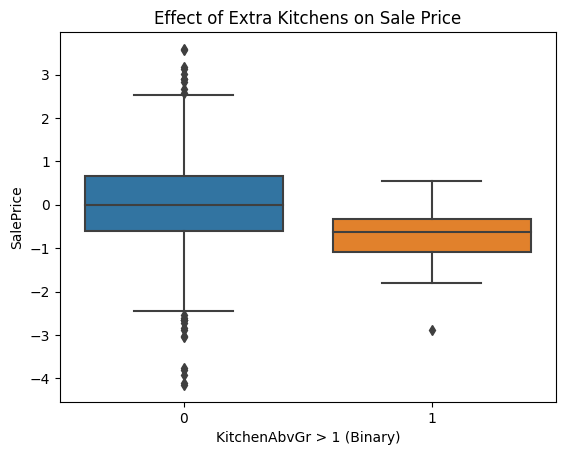

In [55]:
sns.boxplot(x=train_df["KitchenAbvGr_binary"], y=train_df["SalePrice"])
plt.xlabel("KitchenAbvGr > 1 (Binary)")
plt.ylabel("SalePrice")
plt.title("Effect of Extra Kitchens on Sale Price")
plt.show()

In [56]:
train_df.drop(columns=["KitchenAbvGr"], inplace=True)
highly_skewed.remove('KitchenAbvGr')

In [57]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MasVnrArea     0.426258
TotalBsmtSF    0.232534
LotFrontage    0.167283
WoodDeckSF     0.132275
MSSubClass     0.069019
LotArea        0.026569
GrLivArea      0.000171
1stFlrSF      -0.001106
SalePrice     -0.008654
OpenPorchSF   -0.014772
BsmtFinSF1    -0.411401
dtype: float64


# transformation: GarageYrBlt -> GarageYrBlt_Binned

In [58]:
correlation_transformed = train_df['GarageYrBlt'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['GarageYrBlt', 'SalePrice']].corr())
train_df.groupby("GarageYrBlt")["SalePrice"].mean()

Pearson correlation (transformed): 0.3550716251788237
             GarageYrBlt  SalePrice
GarageYrBlt     1.000000   0.355072
SalePrice       0.355072   1.000000


GarageYrBlt
0.0      -1.357967
1900.0   -0.538759
1906.0   -0.517908
1908.0    0.915952
1910.0   -0.731821
1914.0   -0.243437
1915.0   -0.636781
1916.0   -0.702601
1918.0    0.885184
1920.0   -1.335065
1921.0   -0.599834
1922.0   -0.626904
1923.0    0.005571
1924.0   -0.908888
1925.0   -0.409699
1926.0   -0.626147
1927.0   -0.928935
1928.0   -0.782540
1929.0   -0.327148
1930.0   -0.734022
1931.0   -0.308998
1932.0    0.477951
1933.0   -0.471194
1934.0    0.728829
1935.0   -0.562038
1936.0   -0.524797
1937.0   -0.782614
1938.0   -1.690863
1939.0   -0.181060
1940.0   -0.516033
1941.0   -0.875244
1942.0   -0.069103
1945.0   -0.920904
1946.0   -0.861724
1947.0   -0.684802
1948.0   -0.559084
1949.0   -0.765853
1950.0   -0.549572
1951.0   -0.461750
1952.0   -1.435979
1953.0   -0.441465
1954.0   -0.536232
1955.0   -0.456934
1956.0   -0.788784
1957.0   -0.471861
1958.0   -0.655126
1959.0   -0.158024
1960.0   -0.164891
1961.0   -0.508411
1962.0   -0.467436
1963.0   -0.461660
1964.0   -0.211668


In [59]:
bins = [-1, 1, 1940, 1970, 1990, 2000, float('inf')]  # Changed 0 → -1
labels = ['NoGarage', 'Pre1940', '1940-1970', '1970-1990', '1990-2000', 'Post2000']

train_df['GarageYrBlt_Binned'] = pd.cut(train_df['GarageYrBlt'], bins=bins, labels=labels)

In [60]:
if "GarageYrBlt_Binned" in train_df.columns:
    print("it is there")
else:
    print("it is not there")

it is there


In [61]:
print(train_df['GarageYrBlt_Binned'].value_counts(dropna=False))

GarageYrBlt_Binned
1940-1970    397
Post2000     375
1970-1990    277
1990-2000    207
Pre1940      123
NoGarage      81
Name: count, dtype: int64


In [62]:
print(train_df[train_df['GarageYrBlt_Binned'].isna()]['GarageYrBlt'].unique())

[]


In [63]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MasVnrArea     0.426258
TotalBsmtSF    0.232534
LotFrontage    0.167283
WoodDeckSF     0.132275
MSSubClass     0.069019
LotArea        0.026569
GrLivArea      0.000171
1stFlrSF      -0.001106
SalePrice     -0.008654
OpenPorchSF   -0.014772
BsmtFinSF1    -0.411401
dtype: float64


# **Normalising the features**

In [64]:
# 1. Detect binary features (only 0s and 1s)
binary_features = [col for col in train_df.columns if train_df[col].nunique() == 2]

# 2. Detect binned categorical features (few unique values, but >2)
# Assuming binned features have fewer than, say, 10 unique values
binned_features = [col for col in train_df.columns if 2 < train_df[col].nunique() <= 6]

# 3. Detect continuous features (more than 10 unique values)
continuous_features = [col for col in train_df.columns if train_df[col].nunique() > 10]

print("Binary Features:", binary_features)
print("Binned Features:", binned_features)
print("Continuous Features:", continuous_features)

Binary Features: ['MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_None', 'Alley_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Condition1_RRAn

In [65]:
continuous_features = [col for col in continuous_features if col not in ['Id', 'GarageYrBlt']]

In [66]:
print(train_df[continuous_features].head())

   MSSubClass  LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
0    0.493460    -0.146062 -0.141171       2003          2003    1.230708   
1   -1.164269     0.546852  0.105609       1976          1976   -0.818452   
2    0.493460    -0.000631  0.413721       2001          2002    1.193873   
3    0.698191    -0.397299  0.095490       1915          1970   -0.818452   
4    0.493460     0.718695  0.877127       2000          2000    1.333038   

   BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  \
0    0.797537        150    -0.404029 -0.799624       854   0.528531   
1    1.011471        284     0.508177  0.429151         0  -0.382755   
2    0.571325        434    -0.253787 -0.568533       866   0.659112   
3    0.142272        540    -0.644806 -0.429428       756   0.540797   
4    0.750541        490     0.254387  0.124698      1053   1.282894   

   TotRmsAbvGrd  GarageArea  WoodDeckSF  OpenPorchSF  MoSold  SalePrice  
0             8         548   

   MSSubClass  LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
0    0.493460    -0.146062 -0.141171   1.050994      0.878668    1.230708   
1   -1.164269     0.546852  0.105609   0.156734     -0.429577   -0.818452   
2    0.493460    -0.000631  0.413721   0.984752      0.830215    1.193873   
3    0.698191    -0.397299  0.095490  -1.863632     -0.720298   -0.818452   
4    0.493460     0.718695  0.877127   0.951632      0.733308    1.333038   

   BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  \
0    0.797537  -0.944591    -0.404029 -0.799624  1.161852   0.528531   
1    1.011471  -0.641228     0.508177  0.429151 -0.795163  -0.382755   
2    0.571325  -0.301643    -0.253787 -0.568533  1.189351   0.659112   
3    0.142272  -0.061670    -0.644806 -0.429428  0.937276   0.540797   
4    0.750541  -0.174865     0.254387  0.124698  1.617877   1.282894   

   TotRmsAbvGrd  GarageArea  WoodDeckSF  OpenPorchSF    MoSold  SalePrice  
0      0.912210    0.351000 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

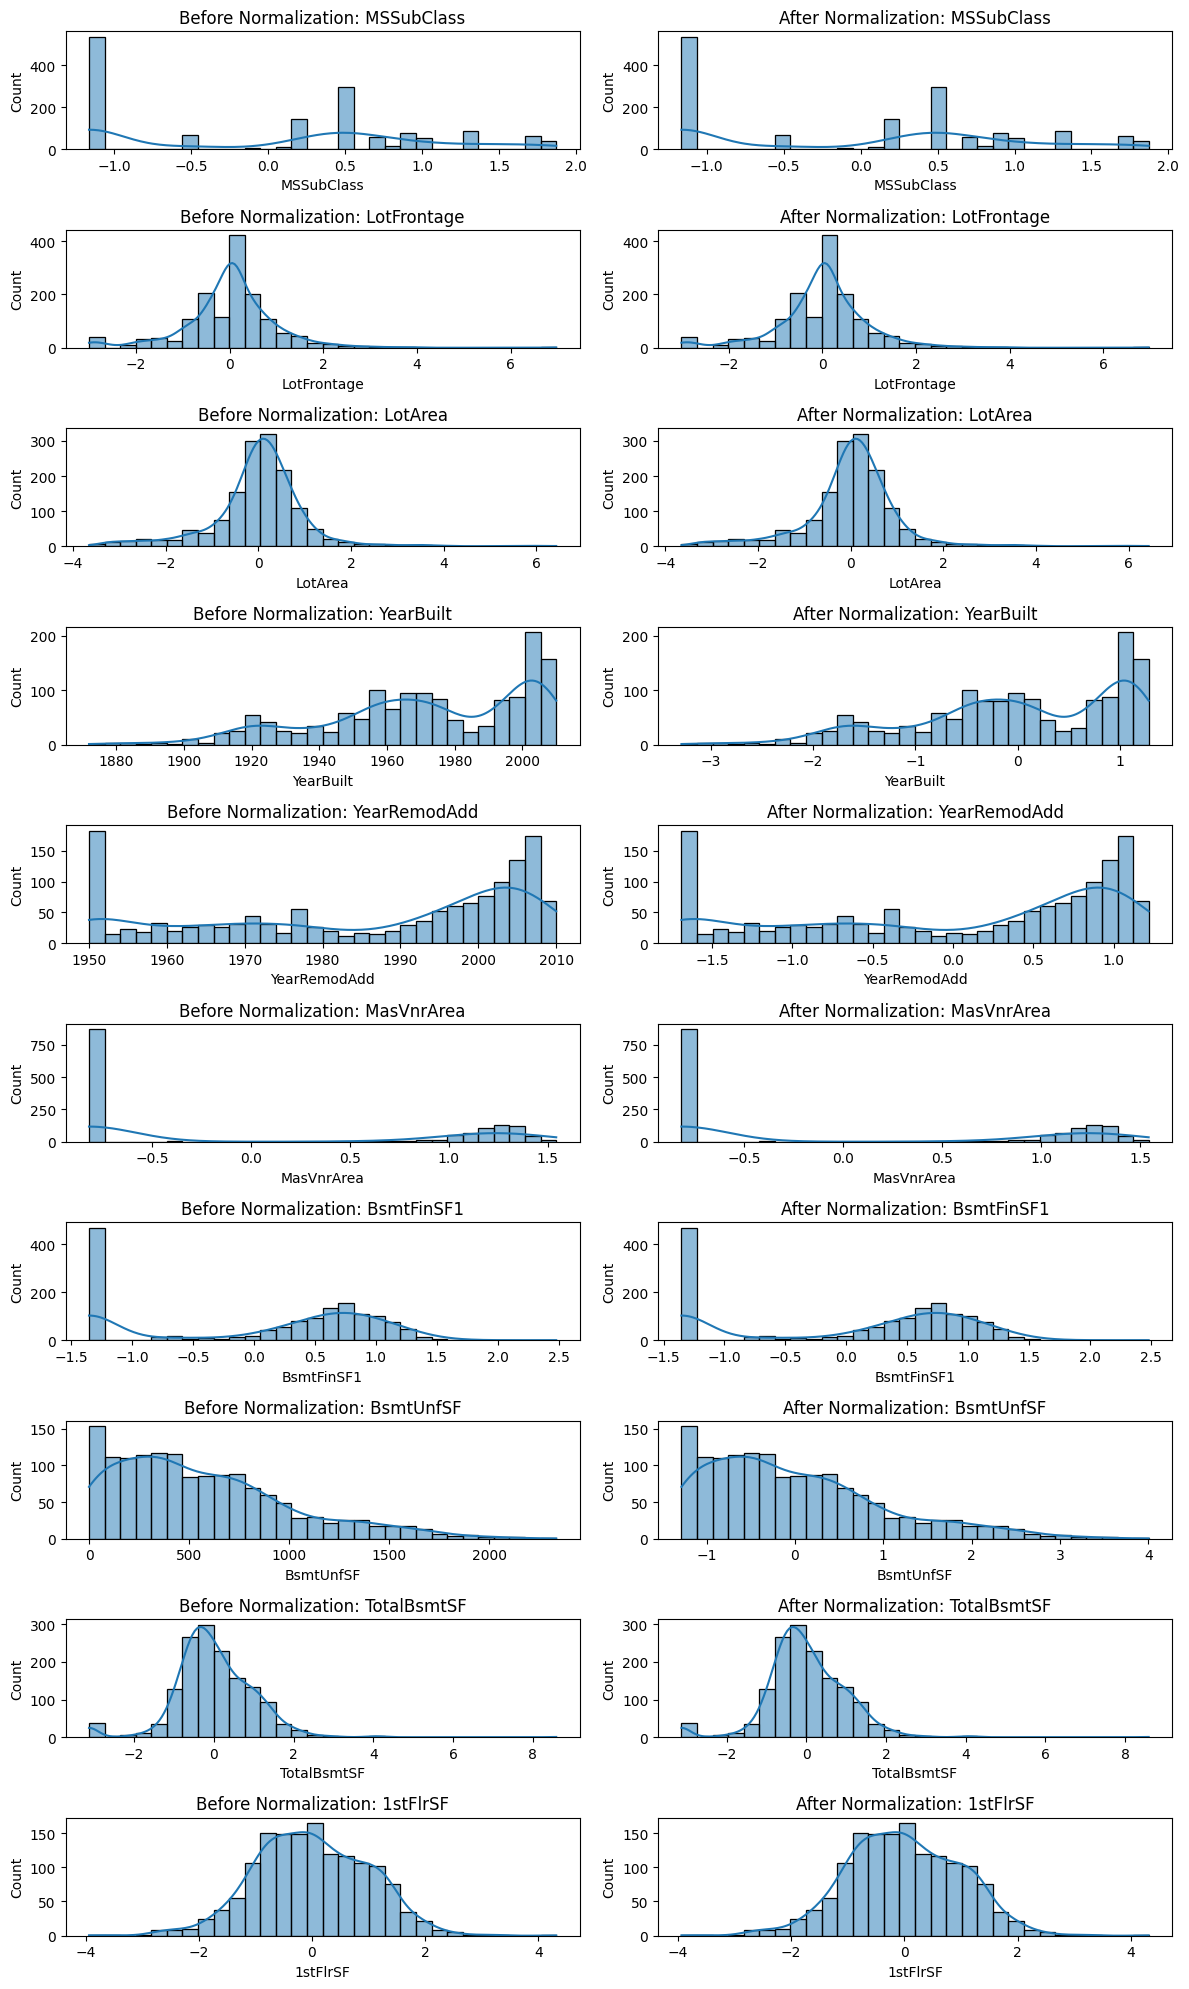

In [67]:
scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[continuous_features] = scaler.fit_transform(train_df[continuous_features])
print(train_df_scaled[continuous_features].head())
# Select a few continuous features to visualize
sample_features = continuous_features[:10] 

# --- Histograms Before vs After Normalization ---
fig, axes = plt.subplots(len(sample_features), 2, figsize=(12, 20))

for i, col in enumerate(sample_features):
    # Before normalization
    sns.histplot(train_df[col], ax=axes[i, 0], kde=True, bins=30)
    axes[i, 0].set_title(f"Before Normalization: {col}")

    # After normalization
    sns.histplot(train_df_scaled[col], ax=axes[i, 1], kde=True, bins=30)
    axes[i, 1].set_title(f"After Normalization: {col}")

plt.tight_layout()
plt.show()

In [68]:
train_df[continuous_features].skew()

MSSubClass      0.069019
LotFrontage     0.167283
LotArea         0.026569
YearBuilt      -0.613461
YearRemodAdd   -0.503562
MasVnrArea      0.426258
BsmtFinSF1     -0.411401
BsmtUnfSF       0.920268
TotalBsmtSF     0.232534
1stFlrSF       -0.001106
2ndFlrSF        0.813030
GrLivArea       0.000171
TotRmsAbvGrd    0.676341
GarageArea      0.179981
WoodDeckSF      0.132275
OpenPorchSF    -0.014772
MoSold          0.212053
SalePrice      -0.008654
dtype: float64

In [69]:
mapping = {
    "Pre1940": 0,
    "1940-1970": 1,
    "1970-1990": 2,
    "1990-2000": 3,
    "Post2000": 4,
    "NoGarage": -1 
}

train_df["GarageYrBlt_Binned"] = train_df["GarageYrBlt_Binned"].map(mapping).astype(int)

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


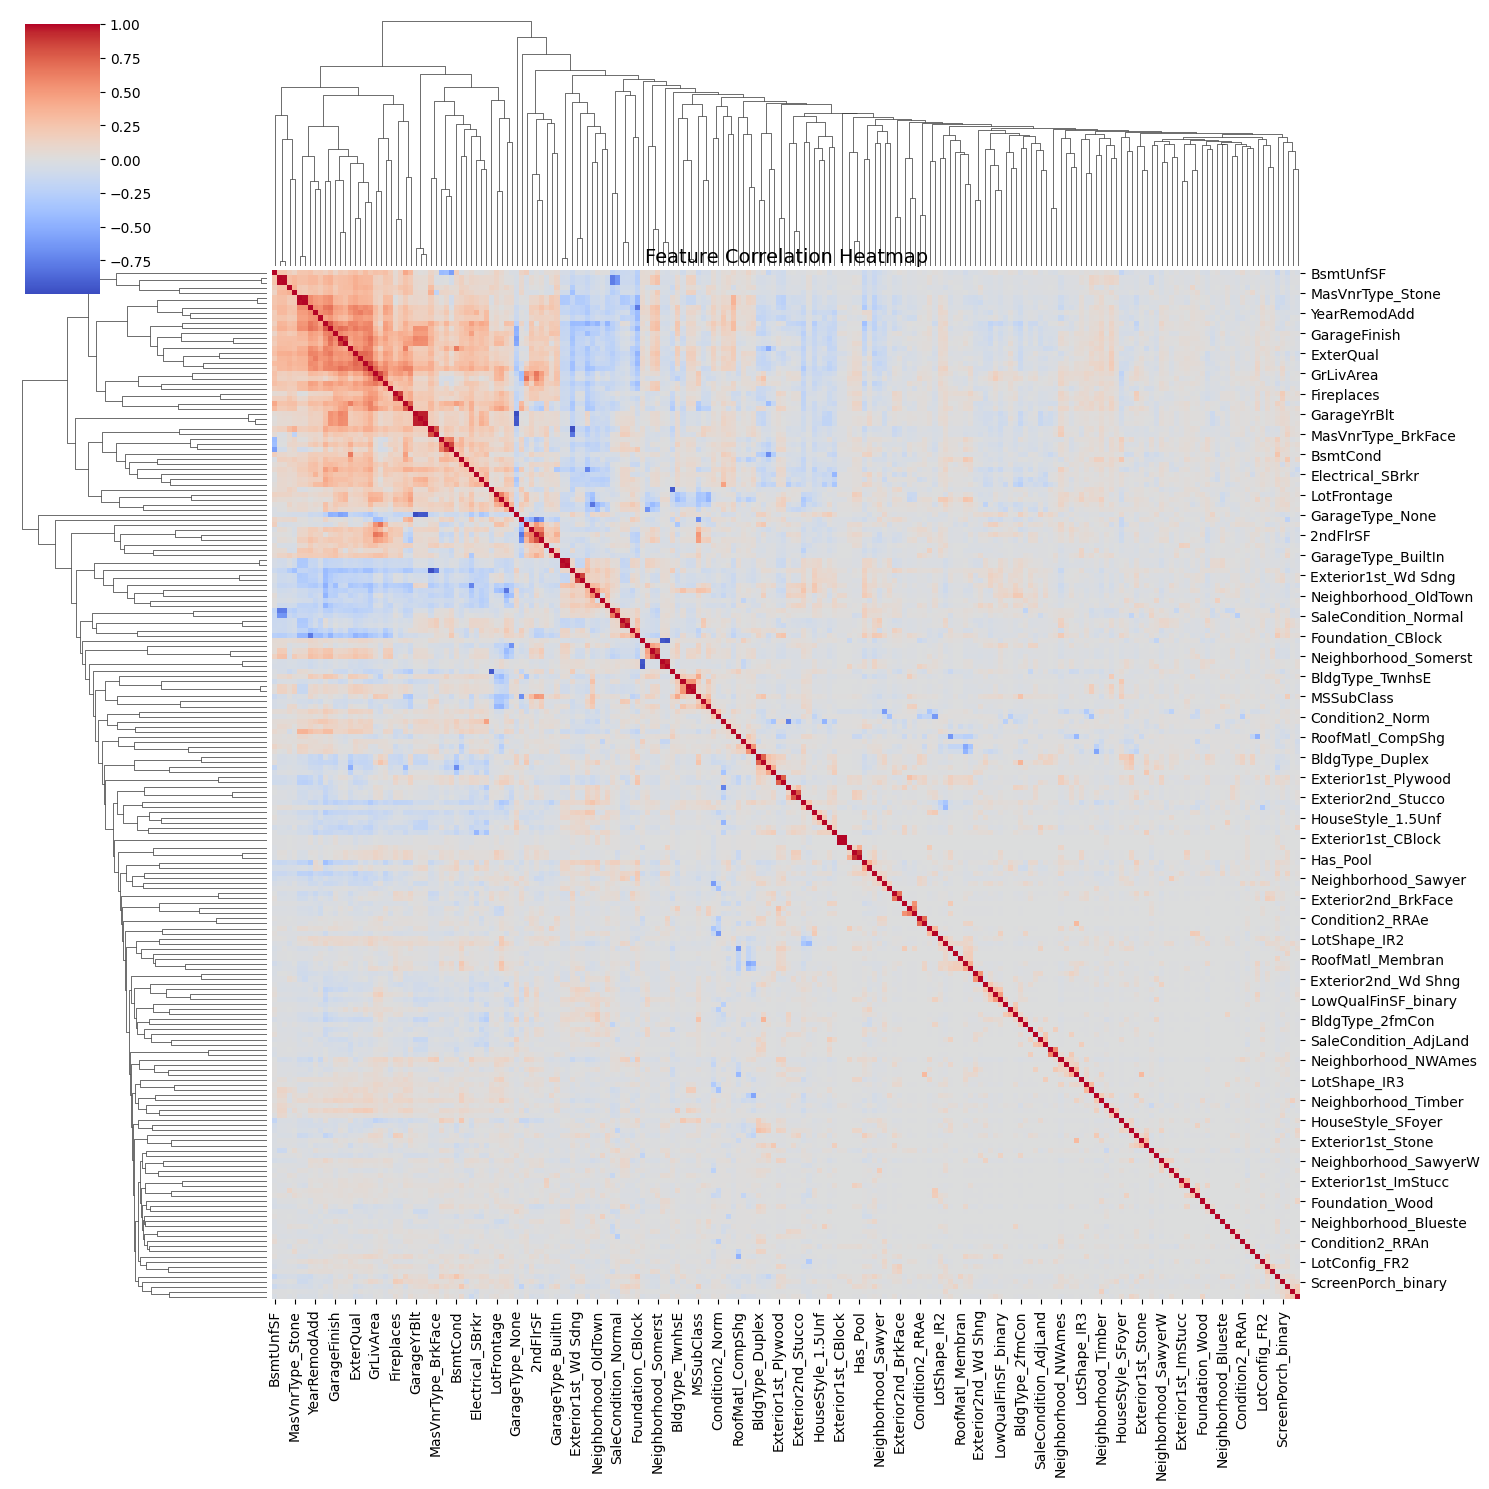

In [70]:
corr_matrix = train_df.corr()

corr_matrix = corr_matrix.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
corr_matrix = corr_matrix.fillna(0)  # Fill NaNs with 0 (or use corr_matrix.dropna())
g = sns.clustermap(corr_matrix, cmap='coolwarm', figsize=(15, 15))

g.ax_heatmap.set_title("Feature Correlation Heatmap", fontsize=14)

plt.show()

In [71]:
threshold = 0.8
corr_matrix = train_df.corr()
highly_correlated_features = np.where(np.abs(corr_matrix) > threshold)

correlated_pairs = [
    (corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
    for i, j in zip(*highly_correlated_features) if i != j
]

# Remove duplicate pairs (since correlation matrix is symmetric)
correlated_pairs = list(set(tuple(sorted(pair[:2])) + (pair[2],) for pair in correlated_pairs))

correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for feature1, feature2, corr_value in correlated_pairs:
    print(f"{feature1} - {feature2}: {corr_value:.2f}")

Exterior1st_CBlock - Exterior2nd_CBlock: 1.00
GarageType_None - GarageYrBlt: -1.00
SaleCondition_Partial - SaleType_New: 0.99
MasVnrArea - MasVnrType_None: -0.99
MiscFeature_None - MiscVal_binary: -0.98
Exterior1st_VinylSd - Exterior2nd_VinylSd: 0.98
Exterior1st_CemntBd - Exterior2nd_CmentBd: 0.97
Exterior1st_MetalSd - Exterior2nd_MetalSd: 0.97
GarageCond - GarageQual: 0.96
MiscFeature_None - MiscFeature_Shed: -0.95
GarageCond - GarageYrBlt: 0.95
MiscFeature_Shed - MiscVal_binary: 0.95
GarageQual - GarageYrBlt: 0.95
GarageCond - GarageType_None: -0.95
GarageQual - GarageType_None: -0.94
RoofStyle_Gable - RoofStyle_Hip: -0.93
Has_Pool - PoolQC: 0.92
Exterior1st_HdBoard - Exterior2nd_HdBoard: 0.88
GarageArea - GarageCars: 0.88
FireplaceQu - Fireplaces: 0.86
MSZoning_FV - Neighborhood_Somerst: 0.86
Exterior1st_Wd Sdng - Exterior2nd_Wd Sdng: 0.86
BsmtFinSF1 - BsmtFinType1: 0.84
GrLivArea - TotRmsAbvGrd: 0.83
OverallQual - SalePrice: 0.82
2ndFlrSF - HouseStyle_2Story: 0.81
MSZoning_RL - MSZ